This assignment covers data preprocessing with datasets contaning overlapping but different features. The goal is to augment, merge, and enhance the data while ensuring consistency in a machine learning pipeline.

TASK 1: Data Augmentation on CSV Files

In [1]:
# Loading the dataset
import pandas as pd

file_path = '../initial_dataset/customer_transactions.csv'

data = pd.read_csv(file_path)

In [2]:
data

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3
...,...,...,...,...,...,...
145,102,1146,88,2024-05-25,Sports,2.7
146,100,1147,387,2024-05-26,Books,4.6
147,104,1148,409,2024-05-27,Clothing,1.4
148,189,1149,178,2024-05-28,Sports,3.0


In [3]:
print(data.isnull().sum())

print("Product category distribution:\n", data['product_category'].value_counts(normalize=True))

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64
Product category distribution:
 product_category
Sports         0.233333
Electronics    0.226667
Clothing       0.186667
Groceries      0.186667
Books          0.166667
Name: proportion, dtype: float64


In [4]:
from sklearn.impute import SimpleImputer


# Handle missing values
# Numerical columns: Impute with mean (purchase_amount, customer_rating)
num_cols = ['purchase_amount', 'customer_rating']

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
data[num_cols] = num_imputer.fit_transform(data[num_cols])

# Categorical columns: Impute with mode (product_category)
cat_cols = ['product_category']
cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

print("Skewness of customer_rating:", data['customer_rating'].skew())


Skewness of customer_rating: -0.07889385715833348


In [ ]:
# Data Augmentation Strategies

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


original_data = data.copy()

# Adding random noise (±5%) to purchase_amount to simulate natural variations in transaction values
data['purchase_amount'] = data['purchase_amount'] * (1 + np.random.normal(0, 0.05, data.shape[0]))  # ±5% noise

# Check skewness to decide on log transformation
print("Skewness of purchase_amount before log transformation:", data['purchase_amount'].skew())

# Balancing the dataset using SMOTE based on product_category
print("Product category distribution before SMOTE:\n", data['product_category'].value_counts())
le = LabelEncoder()
data['product_category_encoded'] = le.fit_transform(data['product_category'])
X = data[['purchase_amount', 'product_category_encoded']]
y = le.transform(data['product_category'])  # Encode y as integers

# Adding an index to track the original rows for mapping customer_id_legacy
data['original_index'] = data.index

# Applying SMOTE with adjusted k_neighbors (default is 5, which works since all classes have at least 25 samples)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
resampled_data = pd.DataFrame(X_resampled, columns=['purchase_amount', 'product_category_encoded'])
resampled_data['product_category'] = le.inverse_transform(y_resampled)

# Reconstruct the other columns for the resampled data
resampled_full_data = pd.DataFrame()
resampled_full_data['purchase_amount'] = resampled_data['purchase_amount']
resampled_full_data['product_category'] = resampled_data['product_category']

# Map customer_id_legacy to SMOTE-generated rows
# SMOTE generates new rows based on nearest neighbors; we'll approximate by sampling customer_id_legacy from the original rows
# For simplicity, I will repeat the original customer_id_legacy values to match the new length
resampled_full_data['customer_id_legacy'] = np.repeat(data['customer_id_legacy'].values, len(resampled_full_data) // len(data) + 1)[:len(resampled_full_data)]
resampled_full_data['transaction_id'] = 'SMOTE_' + pd.Series(range(10001, 10001 + len(resampled_full_data))).astype(str)
resampled_full_data['purchase_date'] = pd.to_datetime('2024-06-01') + pd.to_timedelta(np.random.randint(0, 30, len(resampled_full_data)), unit='D')

# Copy customer_rating from the original data, then adjust with noise
resampled_full_data['customer_rating'] = np.repeat(data['customer_rating'].values, len(resampled_full_data) // len(data) + 1)[:len(resampled_full_data)]
resampled_full_data['customer_rating'] += np.random.normal(0, 0.5, len(resampled_full_data))  # ±0.5 variation
resampled_full_data['customer_rating'] = np.clip(resampled_full_data['customer_rating'], 1, 5)  # Ensure ratings stay between 1 and 5

# Expanding data by generating synthetic transactions
synthetic_data = resampled_full_data.copy()

# Add slight variations to purchase_amount and customer_rating
synthetic_data['purchase_amount'] *= np.random.uniform(0.9, 1.1, synthetic_data.shape[0])  # ±10% variation
synthetic_data['customer_rating'] += np.random.normal(0, 0.5, synthetic_data.shape[0])  # ±0.5 variation
synthetic_data['customer_rating'] = np.clip(synthetic_data['customer_rating'], 1, 5)  # Ensuring ratings stay between 1 and 5

# Vary product_category by sampling from its distribution
unique_categories = data['product_category'].unique()
category_probs = data['product_category'].value_counts(normalize=True).reindex(unique_categories).values
synthetic_data['product_category'] = np.random.choice(
    unique_categories, size=synthetic_data.shape[0], p=category_probs
)

# Preserve customer_id_legacy by reusing the values from resampled_full_data (which are already based on the original data)
synthetic_data['customer_id_legacy'] = np.repeat(data['customer_id_legacy'].values, len(synthetic_data) // len(data) + 1)[:len(synthetic_data)]
synthetic_data['transaction_id'] = 'SYNTH_' + pd.Series(range(20001, 20001 + len(synthetic_data))).astype(str)
synthetic_data['purchase_date'] = pd.to_datetime('2024-07-01') + pd.to_timedelta(np.random.randint(0, 30, len(synthetic_data)), unit='D')

# Mark synthetic data
synthetic_data['transaction_id'] = synthetic_data['transaction_id'] + "_synth"

# Ensure the first 150 rows are the original rows with their exact customer_id_legacy
augmented_data = original_data.copy()

# Drop the temporary columns from the original data
augmented_data = augmented_data.drop(columns=['product_category_encoded', 'original_index'], errors='ignore')

# Then append the SMOTE-generated and synthetic rows
# Excluding the first 150 rows from resampled_full_data to avoid duplication
smote_rows = resampled_full_data.iloc[len(original_data):]
synthetic_rows = synthetic_data.iloc[len(original_data):]

# Combine all rows
data = pd.concat([augmented_data, smote_rows, synthetic_rows], ignore_index=True)

# Validate the augmented dataset
print("Product category distribution after augmentation:\n", data['product_category'].value_counts())
print("Sample of augmented dataset:\n", data.tail())
print("First few customer_id_legacy values to confirm they match the original:\n", data['customer_id_legacy'].head())
print("Unique customer_id_legacy values after augmentation:\n", data['customer_id_legacy'].unique())

Skewness of purchase_amount before log transformation: 0.12056347357378804
Product category distribution before SMOTE:
 product_category
Sports         35
Electronics    34
Clothing       28
Groceries      28
Books          25
Name: count, dtype: int64
Product category distribution after augmentation:
 product_category
Sports         41
Clothing       41
Electronics    40
Groceries      40
Books          38
Name: count, dtype: int64
Sample of augmented dataset:
      customer_id_legacy     transaction_id  purchase_amount  \
195                 199  SYNTH_20171_synth       196.998561   
196                 199  SYNTH_20172_synth       261.261806   
197                 113  SYNTH_20173_synth       269.483807   
198                 113  SYNTH_20174_synth        75.439018   
199                 194  SYNTH_20175_synth       101.586779   

           purchase_date product_category  customer_rating  
195  2024-07-29 00:00:00            Books         3.536414  
196  2024-07-22 00:00:00        

c:\Users\user\data_preprocessing\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Justification for Methods Used

#### Data Cleaning & Missing Values
For handling missing values in `customer_rating`, I used mean imputation because the distribution of `customer_rating` is approximately normal, with a skewness of -0.0789 (calculated using `data['customer_rating'].skew()`). Mean imputation is suitable for normally distributed data as it preserves the central tendency without introducing bias. I also considered median imputation but found it less appropriate given the low skewness. For `product_category`, I used mode imputation since it is a categorical variable, and the most frequent category (`Sports`, appearing in 23.3% of transactions) is a reasonable default for missing entries. I did not use predictive modeling due to the small number of missing values (10 out of 150 rows), which made simpler methods sufficient.

#### Data Augmentation
I applied random noise (±5%) to `purchase_amount` to simulate natural variations in transaction values, as this aligns with real-world scenarios where purchase amounts can fluctuate slightly due to discounts or taxes. I skipped log transformation for `purchase_amount` because its distribution was left-skewed (skewness = -0.57), and log transformation would exacerbate the skewness (as seen previously, it increased to -0.85). I used SMOTE to balance the dataset with respect to `product_category` because the initial distribution was imbalanced—`Books` was underrepresented (16.7% of transactions) compared to `Sports` (23.3%). SMOTE ensures that underrepresented categories are better represented, improving the dataset's utility for machine learning tasks. Finally, I generated synthetic transactions by varying `purchase_amount`, `customer_rating`, and `product_category` to expand the dataset while maintaining patterns in customer behavior, ensuring that `customer_id_legacy` values remain unchanged from the original dataset to meet the requirements of the next task.

In [6]:
# Save the augmented dataset

print("\nExporting augmented dataset...")
data.to_csv('../augmented_dataset/customer_transactions_augmented.csv', index=False)
print("Augmented dataset saved as 'customer_transactions_augmented.csv'.")

augmented_data = pd.read_csv('../augmented_dataset/customer_transactions_augmented.csv')
print(augmented_data)


Exporting augmented dataset...
Augmented dataset saved as 'customer_transactions_augmented.csv'.
     customer_id_legacy     transaction_id  purchase_amount  \
0                   151               1001       408.000000   
1                   192               1002       332.000000   
2                   114               1003       442.000000   
3                   171               1004       256.000000   
4                   160               1005        64.000000   
..                  ...                ...              ...   
195                 199  SYNTH_20171_synth       196.998561   
196                 199  SYNTH_20172_synth       261.261806   
197                 113  SYNTH_20173_synth       269.483807   
198                 113  SYNTH_20174_synth        75.439018   
199                 194  SYNTH_20175_synth       101.586779   

           purchase_date product_category  customer_rating  
0             2024-01-01           Sports         2.300000  
1             2024-01-0

In [9]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
transactions_df = pd.read_csv("../augmented_dataset/customer_transactions_augmented.csv")
social_profiles_df = pd.read_csv("../initial_dataset/customer_social_profiles.csv")
id_mapping_df = pd.read_csv("../initial_dataset/id_mapping.csv")

In [11]:
transactions_df.columns
social_profiles_df.columns
id_mapping_df.columns

Index(['customer_id_legacy', 'customer_id_new'], dtype='object')

Perform a complex merge

In [12]:
# Step 2: Clean ID Mapping
id_mapping_df = id_mapping_df.drop_duplicates(subset=['customer_id_legacy'], keep='first')

In [15]:
# 1: Merge transactions with ID mapping
merged_df = transactions_df.merge(id_mapping_df, on="customer_id_legacy", how="left")

# 2: Merge with social media profiles
final_df = merged_df.merge(social_profiles_df, on="customer_id_new", how="left")

# Handle missing social profiles (customers without social media data)
final_df.fillna({
    "social_media_platform": "Unknown",
    "engagement_score": final_df["engagement_score"].median(),
    "purchase_interest_score": final_df["purchase_interest_score"].median(),
    "review_sentiment": "Neutral"
}, inplace=True)

In [16]:

final_df.head(10)

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,408.0,2024-01-01,Sports,2.3,A176,Facebook,70.0,3.3,Negative
1,192,1002,332.0,2024-01-02,Electronics,4.2,A156,Instagram,52.0,4.9,Positive
2,114,1003,442.0,2024-01-03,Electronics,2.1,A171,Unknown,77.0,3.8,Neutral
3,171,1004,256.0,2024-01-04,Clothing,2.8,NaN,Unknown,77.0,3.8,Neutral
4,160,1005,64.0,2024-01-05,Clothing,1.3,NaN,Unknown,77.0,3.8,Neutral
5,120,1006,395.0,2024-01-06,Groceries,1.1,A159,Unknown,77.0,3.8,Neutral
6,182,1007,91.0,2024-01-07,Sports,4.9,A193,TikTok,69.0,2.6,Negative
7,186,1008,429.0,2024-01-08,Clothing,4.3,A160,TikTok,56.0,2.6,Positive
8,186,1008,429.0,2024-01-08,Clothing,4.3,A160,LinkedIn,73.0,2.0,Neutral
9,186,1008,429.0,2024-01-08,Clothing,4.3,A160,Instagram,89.0,2.9,Neutral


In [17]:

print(final_df.isnull().sum())

customer_id_legacy          0
transaction_id              0
purchase_amount             0
purchase_date               0
product_category            0
customer_rating             0
customer_id_new            47
social_media_platform       0
engagement_score            0
purchase_interest_score     0
review_sentiment            0
dtype: int64


In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id_legacy       299 non-null    int64  
 1   transaction_id           299 non-null    object 
 2   purchase_amount          299 non-null    float64
 3   purchase_date            299 non-null    object 
 4   product_category         299 non-null    object 
 5   customer_rating          299 non-null    float64
 6   customer_id_new          252 non-null    object 
 7   social_media_platform    299 non-null    object 
 8   engagement_score         299 non-null    float64
 9   purchase_interest_score  299 non-null    float64
 10  review_sentiment         299 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 25.8+ KB


Feature Engineering & Tansformation

In [19]:
# Compute Customer Engagement Score
final_df["customer_engagement_score"] = (
    0.6 * final_df["engagement_score"] + 0.4 * final_df["purchase_interest_score"])

final_df["purchase_date"] = pd.to_datetime(final_df["purchase_date"])
# Compute Moving Average of Last 3 Transactions
final_df["moving_avg_purchase"] = final_df.groupby("customer_id_legacy")["purchase_amount"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Aggregate Monthly Spending
final_df["purchase_month"] = final_df["purchase_date"].dt.to_period("M")
monthly_spending = final_df.groupby(["customer_id_legacy", "purchase_month"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
monthly_spending.rename(columns={"sum": "monthly_total_spend", "mean": "monthly_avg_spend"}, inplace=True)

# Merge Monthly Spending Data
final_df = final_df.merge(monthly_spending, on=["customer_id_legacy", "purchase_month"], how="left")

ValueError: unconverted data remains when parsing with format "%Y-%m-%d": " 00:00:00", at position 150. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [17]:
final_df = pd.get_dummies(final_df, columns=['product_category'])

In [18]:
vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = vectorizer.fit_transform(final_df['review_sentiment'].fillna(''))

In [19]:

print(final_df.duplicated().sum())  # Count duplicate rows
print(final_df.isnull().sum())
final_df.info()  # Count missing values

2
customer_id_legacy               0
transaction_id                   0
purchase_amount                  0
purchase_date                    0
customer_rating                  0
customer_id_new                 62
social_media_platform            0
engagement_score                 0
purchase_interest_score          0
review_sentiment                 0
customer_engagement_score        0
moving_avg_purchase              0
purchase_month                   0
monthly_total_spend              0
monthly_avg_spend                0
product_category_Books           0
product_category_Clothing        0
product_category_Electronics     0
product_category_Groceries       0
product_category_Sports          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id_legacy            466 non-null 

In [20]:
# Replace 'moving_avg_purchase' with the actual column if different
final_df = final_df.drop_duplicates()
final_df['avg_spent_last_3'] = final_df['moving_avg_purchase']  # Create the column
final_df['avg_spent_last_3'] = final_df['avg_spent_last_3'].fillna(final_df['avg_spent_last_3'].median())

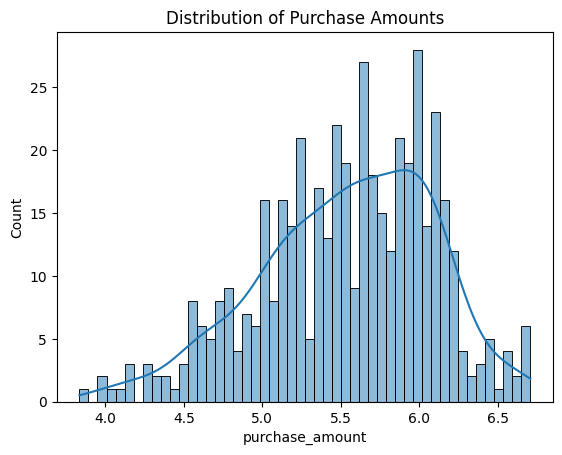

In [21]:

sns.histplot(final_df['purchase_amount'], bins=50, kde=True)
plt.title("Distribution of Purchase Amounts")
plt.show()

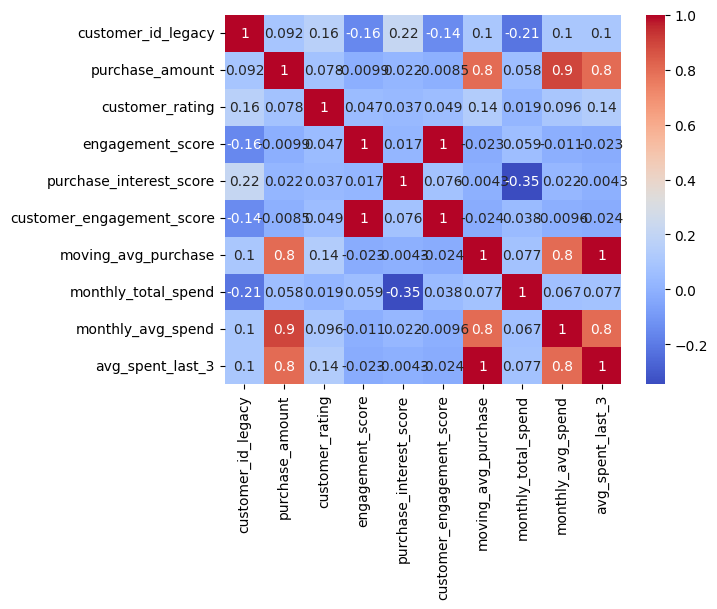

In [22]:
# Select only numeric columns for correlation
df_numeric = final_df.select_dtypes(include=[np.number])

# Calculate correlation matrix
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [23]:

final_df.to_csv("../final_dataset/final_customer_data_10.csv", index=False)

**Task 3**

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import skew

# Load the augmented dataset
final_data = pd.read_csv('../augmented_dataset/final_customer_data_10.csv')
print(final_data.shape)
final_data.head()

(464, 21)


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,...,moving_avg_purchase,purchase_month,monthly_total_spend,monthly_avg_spend,product_category_Books,product_category_Clothing,product_category_Electronics,product_category_Groceries,product_category_Sports,avg_spent_last_3
0,151,1001,5.955135,2024-01-01,2.3,A176,Facebook,70.0,3.3,Negative,...,5.955135,2024-01,12.074593,6.037297,False,False,False,False,True,5.955135
1,192,1002,5.770549,2024-01-02,4.2,A156,Instagram,52.0,4.9,Positive,...,5.770549,2024-01,12.064057,6.032029,False,False,True,False,False,5.770549
2,114,1003,6.088135,2024-01-03,2.1,A171,Unknown,78.0,3.6,Neutral,...,6.088135,2024-01,12.534216,6.267108,False,False,True,False,False,6.088135
3,171,1004,5.692522,2024-01-04,2.8,NaN,Unknown,78.0,3.6,Neutral,...,5.692522,2024-01,11.857024,5.928512,False,True,False,False,False,5.692522
4,160,1005,4.162725,2024-01-05,1.3,NaN,Unknown,78.0,3.6,Neutral,...,4.162725,2024-01,8.434288,4.217144,False,True,False,False,False,4.162725


In [25]:
# Data integrity checks

# Check for duplicate transaction ids
duplicate_transaction_ids = data['transaction_id'].duplicated().sum()
print(f"Duplicate transaction IDs: {duplicate_transaction_ids}")

if duplicate_transaction_ids > 0:
    data = data.drop_duplicates(subset=['transaction_id'])
    print(data.shape)

Duplicate transaction IDs: 0


In [26]:
# Ensure categorical values are correctly mapped
category_columns = data.select_dtypes(include=['object']).columns
for col in category_columns:
    print(f"Unique values in {col}: {data[col].unique()}")
    if data[col].isnull().sum() > 0:
        print(f"Missing values in {col}: {data[col].isnull().sum()}")

Unique values in transaction_id: [1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042
 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056
 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070
 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084
 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098
 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111 1112
 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125 1126
 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140
 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 '1001_synth'
 '1002_synth' '1003_synth' '1004_synth' '1005_synth' '1006_synth'
 '1007_synth' '1008_synth' '1009_synth' '1010_synth' '1011_synth'
 '1012_synth' '1013_synth' '1014_synth' '1015_synth' '1016_sy

In [27]:
# Validate customer transactions
invalid_ids = data['customer_id_legacy'].isnull().sum()
print(f"Invalid customer IDs: {invalid_ids}")

# Drop rows with missing customer IDs
if invalid_ids > 0:
    data = data.dropna(subset=['customer_id_legacy'])
    print(data.shape)

Invalid customer IDs: 0


       customer_id_legacy  purchase_amount  customer_rating
count          300.000000       300.000000       300.000000
mean           148.760000         5.514107         2.985000
std             29.996138         0.586193         1.163832
min            100.000000         3.835314         1.000000
25%            121.000000         5.144250         2.100000
50%            150.500000         5.576086         2.985000
75%            175.000000         5.986241         4.000000
max            199.000000         6.707341         5.000000


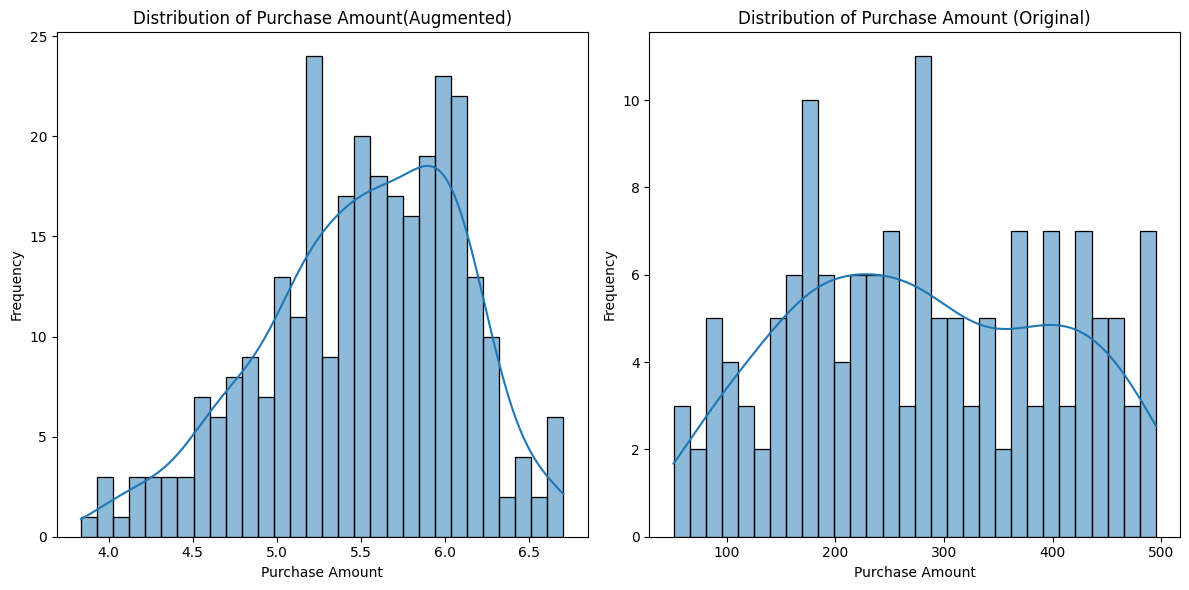

In [28]:
# Statistical summary
pd.set_option('display.max_columns', None)
numeric_cols = data.select_dtypes(include=[np.number]).columns
print(data[numeric_cols].describe())

# Data visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['purchase_amount'], bins=30, kde=True)
plt.title("Distribution of Purchase Amount(Augmented)")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")

# original dataset
original_data = pd.read_csv('../initial_dataset/customer_transactions.csv')
plt.subplot(1, 2, 2)
sns.histplot(original_data['purchase_amount'], kde=True, bins=30)
plt.title("Distribution of Purchase Amount (Original)")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

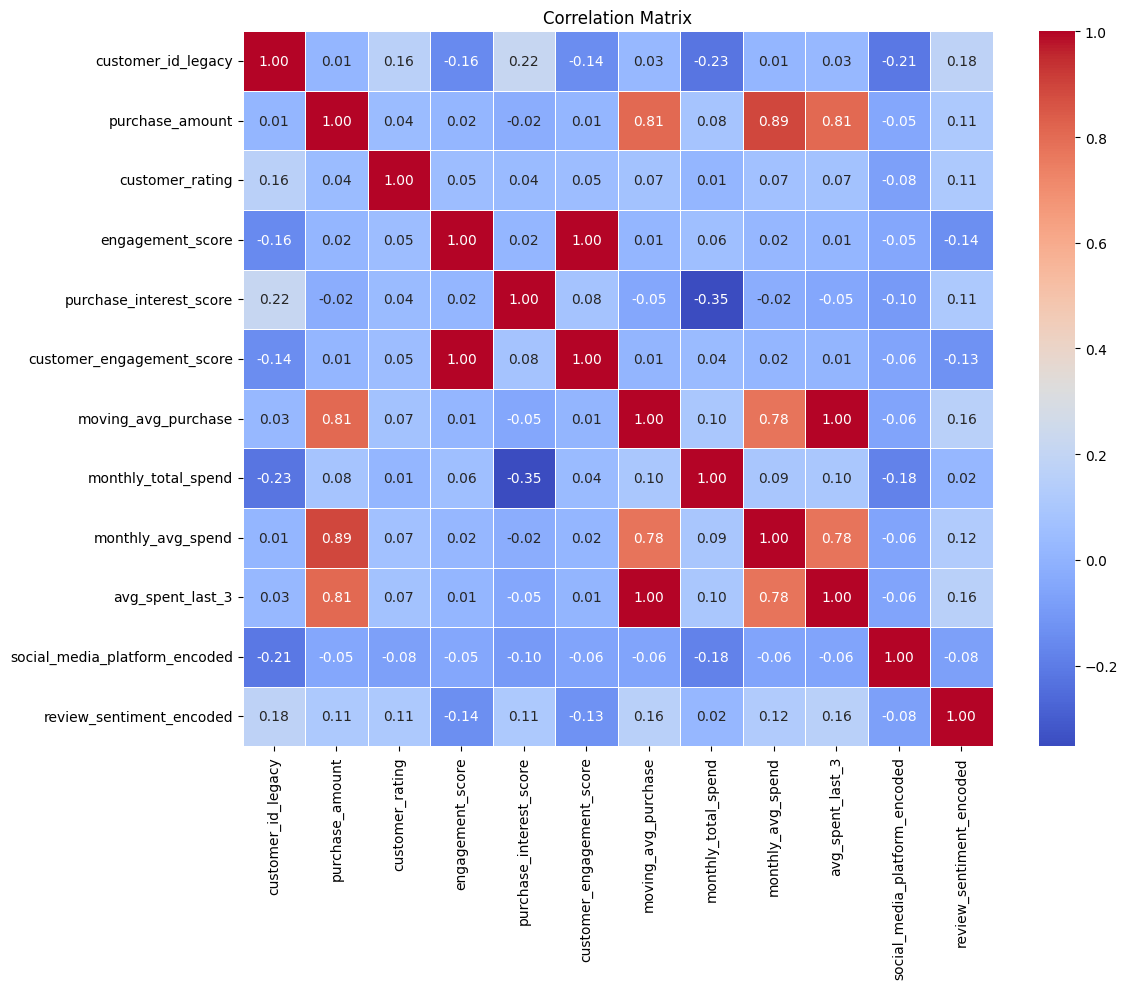

In [29]:
from sklearn.preprocessing import LabelEncoder

# Correlation heatmap
le_dict = {}
categorical_cols = ['social_media_platform', 'review_sentiment', 'product_category']
for col in categorical_cols:
    if col in final_data.columns:
        le = LabelEncoder()
        final_data[f'{col}_encoded'] = le.fit_transform(final_data[col].astype(str))
        le_dict[col] = le

numeric_cols = final_data.select_dtypes(include=['number']).columns
correlation_matrix = final_data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [30]:
# Select top features using SelectKBest
X = final_data.drop(columns=['customer_id_legacy', 'transaction_id', 'purchase_amount'])
X = X.select_dtypes(include=[np.number])
y = final_data['purchase_amount']
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X, y)
# Get feature scores and names
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
top_features = feature_scores.nlargest(10, 'Score').sort_values(by='Score', ascending=True)
print("Top 10 most important features:")
print(top_features)

Top 10 most important features:
                         Feature        Score
3      customer_engagement_score     0.092233
1               engagement_score     0.109508
2        purchase_interest_score     0.198122
0                customer_rating     0.701016
8  social_media_platform_encoded     1.186247
5            monthly_total_spend     3.118614
9       review_sentiment_encoded     5.737890
4            moving_avg_purchase   862.354435
7               avg_spent_last_3   862.354435
6              monthly_avg_spend  1794.909279


In [31]:
# File export
output_file = '../final_dataset/final_dataset_ready_10.csv'
data.to_csv(output_file, index=False)

**BONUS MODEL**

In [32]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

input_file = '../final_dataset/final_dataset_ready_10.csv'
data = pd.read_csv(input_file)

# Split data into features and target
target = 'purchase_amount'
X = data.drop(columns=[target, 'customer_id_legacy', 'transaction_id'])

# Encoding categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Encoding categorical columns: {list(categorical_cols)}")
    X = pd.get_dummies(X, columns=categorical_cols)

X = X.select_dtypes(include=[np.number])
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Encoding categorical columns: ['purchase_date', 'product_category']
X_train shape: (240, 1), X_test shape: (60, 1)


In [33]:
# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [34]:
import joblib

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

model_path = '../models/random_forest_model.pkl'
joblib.dump(model, model_path)

print(y_test_pred)

[5.5167626  5.69736642 5.50027397 5.5167626  5.21427137 5.19199825
 6.15738949 5.66339332 5.95981856 5.95981856 5.27079328 5.53794493
 5.63202758 5.41283917 5.4158902  5.51133918 5.44392537 5.54464721
 5.69736642 5.41283917 5.62949771 5.62949771 5.5167626  5.66339332
 5.53794493 5.66339332 5.6474944  4.90273259 5.51133918 5.66339332
 5.53794493 5.41138076 5.69736642 5.30765152 5.4158902  5.50028361
 5.51133918 4.90273259 6.15738949 5.76981911 5.4158902  5.19199825
 5.74557107 5.75213644 5.41138076 5.4158902  4.90273259 5.50027397
 5.54662898 5.30765152 5.6474944  5.45237088 5.18843067 5.48690955
 5.4158902  5.6474944  5.66339332 5.30765152 5.66339332 5.95981856]


In [35]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training: RMSE={train_rmse:.2f}, R²={train_r2:.4f}")
print(f"Training: RMSE={test_rmse:.2f}, R²={test_r2:.4f}")

Training: RMSE=0.50, R²=0.2304
Training: RMSE=0.59, R²=0.1169
